# Importing data

To run this example you must download the data you want to use for prediction. In this case I download the train data from:
> INTA_URL = "http://siga2.inta.gov.ar/document/series/A872801.xls"

and the test data from:
> INTA_URL = "http://siga2.inta.gov.ar/document/series/A872810.xls"

Feel free to usa any dataset that you like.

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


# Download data

In [3]:
import urllib.request
# Download the file from `url` and save it locally under `file_name`:
INTA_URL = "http://siga2.inta.gov.ar/document/series/A872801.xls"
urllib.request.urlretrieve(INTA_URL, 'resources/inta.xls')

('resources/inta.xls', <http.client.HTTPMessage at 0x7f8ede698dd8>)

In [4]:
dataset = pd.read_excel('resources/inta.xls', sheet_name='Datos diarios')

In [5]:
dataset.head()

,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_5cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_5cm_Media,Temperatura_Suelo_10cm_Media,Temperatura_Inte_5cm,Temperatura_Intemperie_150cm_Minima,...,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
0,2009-08-06 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,NaN,NaN
1,2009-08-07 00:00:00.0,9.572915,12.3,7.3,NaN,NaN,NaN,9.702779,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,1.494000,NaN
2,2009-08-08 00:00:00.0,8.314584,17.4,1.7,NaN,NaN,NaN,9.373611,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,13.612010,13.363010
3,2009-08-09 00:00:00.0,7.433333,17.1,0.8,NaN,NaN,NaN,8.793056,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,13.944010,13.944010
4,2009-08-10 00:00:00.0,11.295140,22.2,3.9,NaN,NaN,NaN,8.979861,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,7.801996,3.236999


In [6]:
#Drop unwanted columns 
dataset.drop('Fecha', axis=1, inplace=True)

# Replace missing data with UNK 
dataset.replace(r'^\s*$', 'UNK', regex=True)


# Drop empty columns
dataset.dropna(how='all', axis=1, inplace=True)


dataset.index.name = 'Fecha'

# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Reorder Precipitaciones
cols = dataset.columns.tolist()
dataset = dataset[cols[6:] + cols[0:5]]

dataset.to_csv('resources/inta-clean.csv')

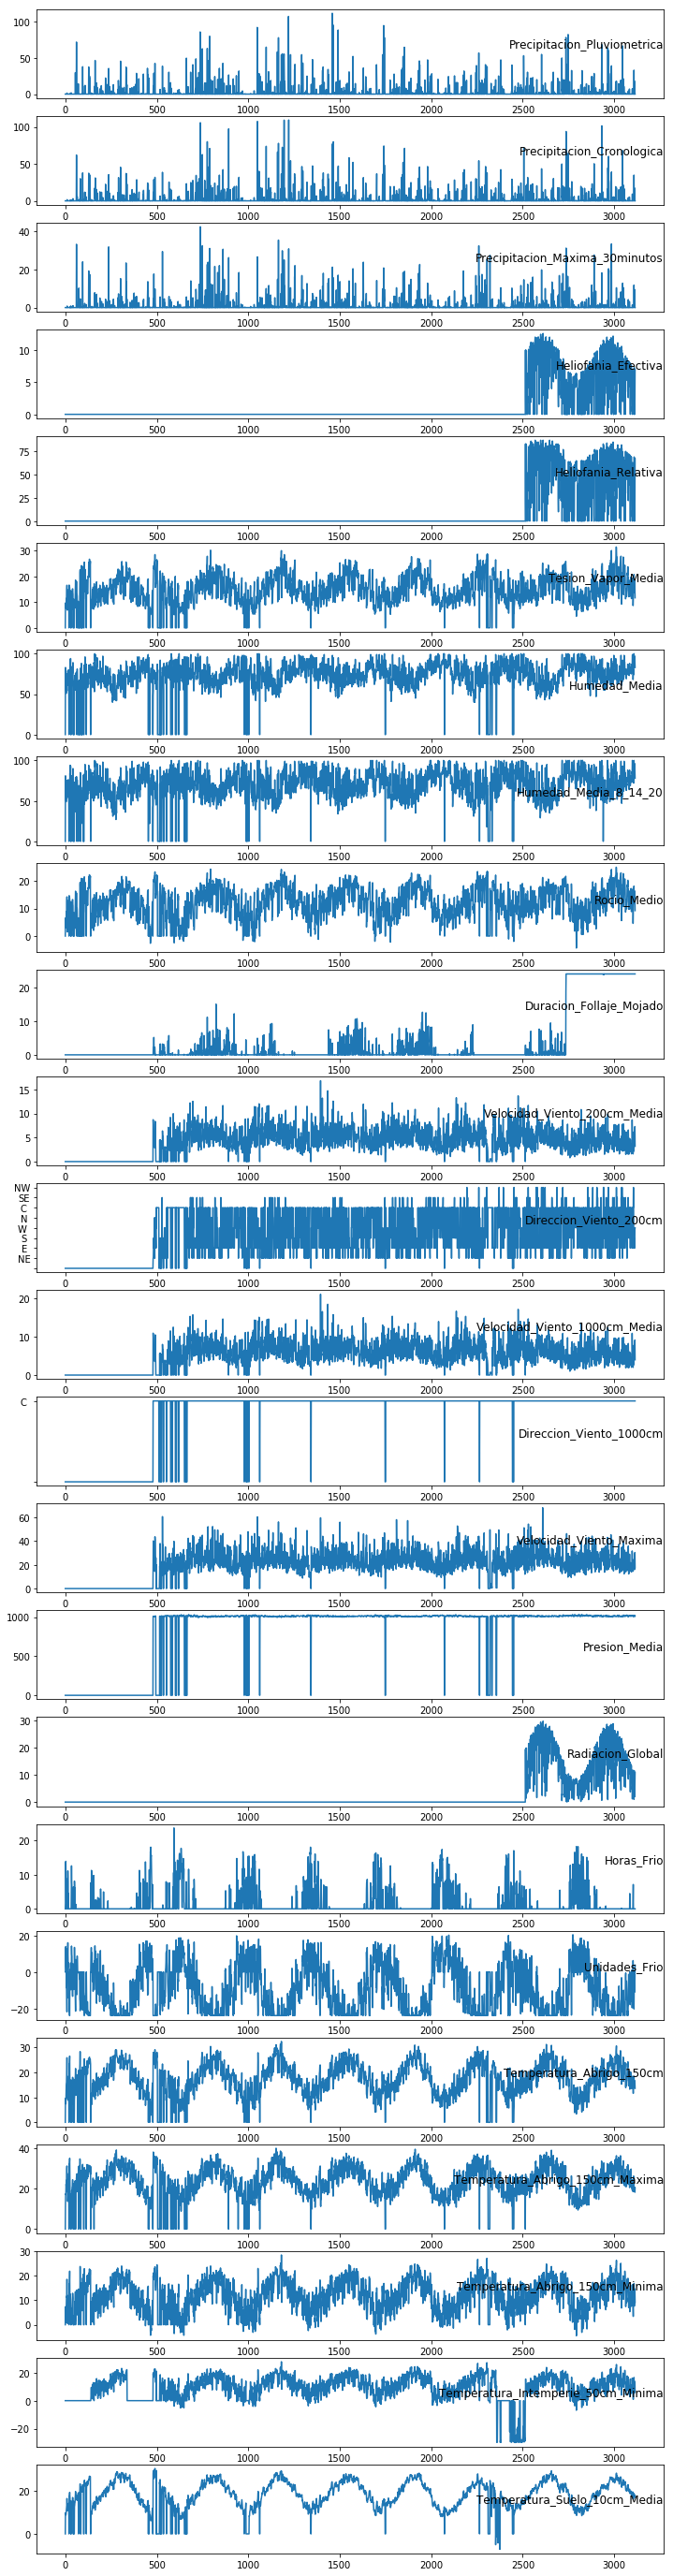

In [7]:
values = dataset.values
# specify columns to plot
i = 1
groups = range(dataset.shape[1])
# plot each column
pyplot.rcParams["figure.figsize"] = [12, 50]

pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()
pyplot.rcParams["figure.figsize"] = [12, 9]

In [8]:
dataset.head(10)

,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Heliofania_Efectiva,Heliofania_Relativa,Tesion_Vapor_Media,Humedad_Media,Humedad_Media_8_14_20,Rocio_Medio,Duracion_Follaje_Mojado,...,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_10cm_Media
Fecha,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,9.712307,83.0,81.0,6.544751,0.0,...,0.0,0.0,0.0,1.494000,0.000000,9.572915,12.3,7.3,0.0,9.702779
2,0.0,0.0,0.0,0.0,0.0,8.052779,81.0,77.0,3.762041,0.0,...,0.0,0.0,0.0,13.612010,13.363010,8.314584,17.4,1.7,0.0,9.373611
3,0.0,0.0,0.0,0.0,0.0,7.681013,77.0,73.0,3.135792,0.0,...,0.0,0.0,0.0,13.944010,13.944010,7.433333,17.1,0.8,0.0,8.793056
4,0.0,0.0,0.0,0.0,0.0,7.810816,58.0,52.0,3.396338,0.0,...,0.0,0.0,0.0,7.801996,3.236999,11.295140,22.2,3.9,0.0,8.979861
5,0.0,0.0,0.0,0.0,0.0,7.763989,51.0,49.0,3.161446,0.0,...,0.0,0.0,0.0,0.000000,0.415001,13.847910,21.2,8.1,0.0,10.147220
6,0.0,0.0,0.0,0.0,0.0,11.458800,64.0,57.0,8.932193,0.0,...,0.0,0.0,0.0,0.000000,-8.631999,15.515280,24.1,9.0,0.0,10.875000
7,0.0,0.0,0.0,0.0,0.0,10.417280,63.0,61.0,7.180822,0.0,...,0.0,0.0,0.0,0.000000,-4.232996,15.934720,19.7,11.6,0.0,11.961800
8,0.0,0.0,0.0,0.0,0.0,14.784580,61.0,54.0,12.679470,0.0,...,0.0,0.0,0.0,0.000000,-12.699010,19.135410,30.0,11.2,0.0,13.084720


# Visualize data
Use Tensorflow tools to quikly visualize the data stats.

In [9]:
import tensorflow_data_validation as tfdv

train_stats = tfdv.generate_statistics_from_csv("resources/inta-clean.csv")
tfdv.visualize_statistics(train_stats)

/home/raulparola/Descargas/Practica/.venv3/lib/python3.6/site-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


# Prepare data
For getting better results when training the model

In [10]:
# Categorize label columns
for c in ['Direccion_Viento_200cm', 'Direccion_Viento_1000cm']:
    lbl = LabelEncoder() 
    lbl.fit(list(dataset[c].values)) 
    dataset[c] = lbl.transform(list(dataset[c].values))

values = dataset.values

# ensure all data is float
values = values.astype('float32')
    
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(3115, 24)


# Convert series to supervised learning
Shift the data N times, in order to get data from the past to match a present value.

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


reframed = series_to_supervised(scaled, 1, 1)

# Drop all features corresponding to this time. 24-45. Remains the 23 column as output
reframed.drop(reframed.columns[[25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var1(t)
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.148366,0.0,...,0.0,0.0,0.000000,0.539326,0.000000,0.0000,0.136778,0.518135,0.190912,0.0
2,0.0,0.0,0.0,0.0,0.0,0.308171,0.83,0.81,0.372052,0.0,...,0.0,0.0,0.062937,0.539326,0.295049,0.3075,0.358663,0.518135,0.451326,0.0
3,0.0,0.0,0.0,0.0,0.0,0.255514,0.81,0.77,0.276945,0.0,...,0.0,0.0,0.573426,0.840824,0.256266,0.4350,0.188450,0.518135,0.442492,0.0
4,0.0,0.0,0.0,0.0,0.0,0.243718,0.77,0.73,0.255541,0.0,...,0.0,0.0,0.587412,0.853932,0.229105,0.4275,0.161094,0.518135,0.426910,0.0
5,0.0,0.0,0.0,0.0,0.0,0.247837,0.58,0.52,0.264446,0.0,...,0.0,0.0,0.328671,0.612360,0.348130,0.5550,0.255319,0.518135,0.431924,0.0


# Split data
Into train and test, also features and results

In [15]:
X, Y = reframed.values[:, :-1], reframed.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# reshape input to match LSTM expected shape 3D [samples, timesteps, features]
train_X = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
test_X = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

(2491, 1, 24) (2491,) (623, 1, 24) (623,)


# Build the model and train

Train on 2491 samples, validate on 623 samples
Epoch 1/10
 - 1s - loss: 0.0334 - val_loss: 0.0287
Epoch 2/10
 - 0s - loss: 0.0266 - val_loss: 0.0282
Epoch 3/10
 - 0s - loss: 0.0261 - val_loss: 0.0282
Epoch 4/10
 - 0s - loss: 0.0261 - val_loss: 0.0284
Epoch 5/10
 - 0s - loss: 0.0261 - val_loss: 0.0282
Epoch 6/10
 - 0s - loss: 0.0260 - val_loss: 0.0281
Epoch 7/10
 - 0s - loss: 0.0260 - val_loss: 0.0281
Epoch 8/10
 - 0s - loss: 0.0260 - val_loss: 0.0281
Epoch 9/10
 - 0s - loss: 0.0260 - val_loss: 0.0281
Epoch 10/10
 - 0s - loss: 0.0260 - val_loss: 0.0281


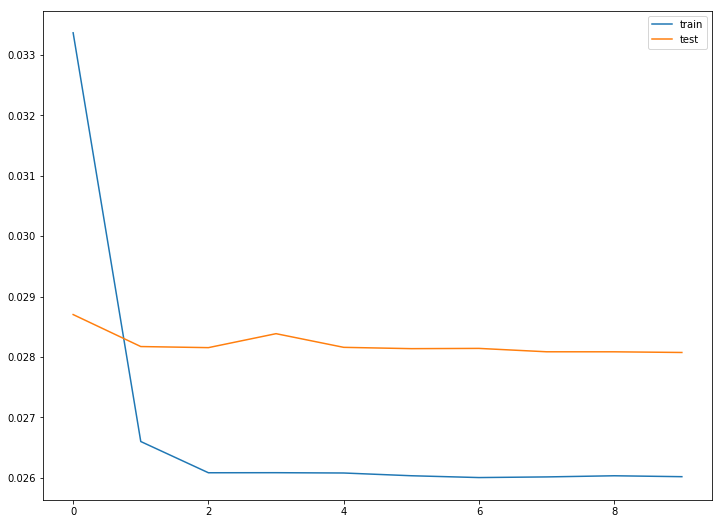

In [16]:
EPOCHS = 10
BATCH = 32

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    validation_data=(test_X, y_test),
                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:
def testModel(x, y):
    # make a prediction
    yhat = model.predict(x)
    x_test = x.reshape((x.shape[0], x.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = y.reshape((len(y), 1))
    inv_y = np.concatenate((test_y, x_test[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)

testModel(test_X, y_test)

Test RMSE: 11.723


# Now let's try this with real data from another INTA Station

In [19]:
# Download the file from `url` and save it locally under `file_name`:
INTA_URL = "http://siga2.inta.gov.ar/document/series/A872810.xls"
urllib.request.urlretrieve(INTA_URL, 'resources/inta-test.xls')
dataset = pd.read_excel('resources/inta-test.xls', sheet_name='Datos diarios')

In [20]:
dataset.drop('Fecha', axis=1, inplace=True)

dataset.replace(r'^\s*$', 'UNK', regex=True)
dataset.dropna(how='all', axis=1, inplace=True)

dataset.index.name = 'Fecha'
dataset.fillna(0, inplace=True)

# Reorder Precipitaciones
cols = dataset.columns.tolist()
dataset = dataset[cols[6:] + cols[0:5]]

# Categorize label columns
for c in ['Direccion_Viento_200cm', 'Direccion_Viento_1000cm']:
    lbl = LabelEncoder() 
    lbl.fit(list(dataset[c].values)) 
    dataset[c] = lbl.transform(list(dataset[c].values))

values = dataset.values

# ensure all data is float
values = values.astype('float32')
    
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(2473, 24)


In [21]:
reframed = series_to_supervised(scaled, 1, 1)
# Drop all features corresponding to this time. 24-45. Remains the 23 column as output
reframed.drop(reframed.columns[[25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var1(t)
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.00,0.218673,0.000000,...,0.000000,0.0,0.000000,0.530387,0.000000,0.000000,0.105442,0.111486,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.164860,0.81,0.00,0.372338,0.461968,...,0.683941,0.0,0.000000,0.677716,0.245099,0.000000,0.105442,0.111486,0.310576,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.175592,0.82,0.79,0.392744,0.608514,...,0.683941,0.0,0.076923,0.677716,0.276676,0.480769,0.292517,0.297297,0.314254,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.221527,0.88,0.85,0.465638,0.466156,...,0.683941,0.0,0.055944,0.550645,0.305722,0.456731,0.302721,0.277027,0.335121,0.196899
5,0.196899,0.173973,0.301449,0.0,0.0,0.283715,0.88,0.92,0.547040,0.339149,...,0.683941,0.0,0.000000,0.290976,0.425180,0.600962,0.595238,0.594595,0.403503,0.000000


In [23]:
# Prepare for Model
X, Y = reframed.values[:, :-1], reframed.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
x_val = np.concatenate([x_train, x_test])
y_val = np.concatenate([y_train, y_test])
# reshape input to be 3D [samples, timesteps, features]
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(x_val.shape, y_val.shape)

(2472, 1, 24) (2472,)


In [24]:
testModel(x_val, y_val)

Test RMSE: 9.086


In [28]:
maxPrec = dataset.Precipitacion_Pluviometrica.max()
meanPrec = dataset.Precipitacion_Pluviometrica.mean()
print("Mean: %d, Max: %d" % (meanPrec, maxPrec))

Mean: 2, Max: 129


# Conclusion
Since the data mainly contains zeros (73.93%), and a max value of 129mm. The actual prediction is realy close. +-3mm.

Using INTA daily data is not enough to get a "state-of-the-art" prediction, maybe I will use hourly data in a future to get more accurate results.